In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files unde|r the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


# Titanic Dataset


### In this notebook, we're going to analyse the famous Titanic dataset from Kaggle. The dataset is meant for supervised machine learning and we're going to do some exploratory analysis and model building to the dataseet

In [97]:
import pandas as pd
import numpy as np
import matplotlib
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.graph_objs as go
%matplotlib inline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, gradient_boosting
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,recall_score,precision_score,f1_score
from xgboost import XGBClassifier

In [ ]:
train_data = pd.read_csv('../input/titanic/train.csv')

In [16]:
train_data.shape

(891, 12)

In [17]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.shape

(418, 11)

In [72]:
train_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889,891
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3,3
top,NaN,NaN,NaN,"Alexander, Mr. William",male,NaN,NaN,NaN,347082,NaN,G6,S,male
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644,537
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN,NaN


### 1 in the Survived column means that the person survived, while a 0 mean that they died. So looking at the mean, we can say that 38% people survived and the average age of the person travelling in the ship is 29.

In [74]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Person       891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


### From above, we see that that the dataset has few missing values. We'll deal those missing values in our further analysis.

In [75]:
cat_col = ['Survived','Pclass','Sex','SibSp','Parch']
for cat in cat_col:
    train_data[cat] = train_data[cat].astype('category')

In [78]:
train_data['Age'] = train_data['Age'].astype('int64')

In [79]:
train_data['Survived'] = train_data['Survived'].replace(to_replace=[0, 1], value=['No', 'Yes'])

In [ ]:
#Function to detect if a person is a man, woman or child.
def man_wom_chi(passenger):
    age=passenger['Age']
    sex=passenger['Sex']
    
    return 'child' if age < 16 else sex

#Using Pandas' apply method to create a new column "Person"
train_data['Person'] = train_data.apply(man_wom_chi,axis=1)

In [ ]:
def barplot(column,train_data):
    bar_plot1 = sns.countplot(x=column,data=train_data)

    total = len(train_data[column])
    for p in bar_plot1.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        height = p.get_height()
        bar_plot1.text(p.get_x() + p.get_width()/2, height, percentage,ha='center')

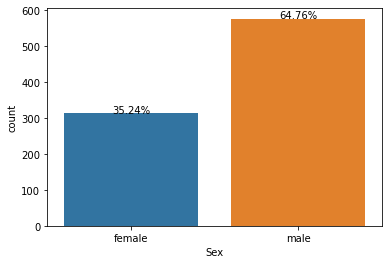

In [82]:
barplot('Sex',train_data)

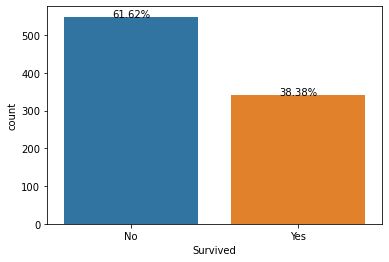

In [83]:
barplot('Survived',train_data)

## Where did the passengers come from?

### The Embarked attribute contains data for the passengers' port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton).

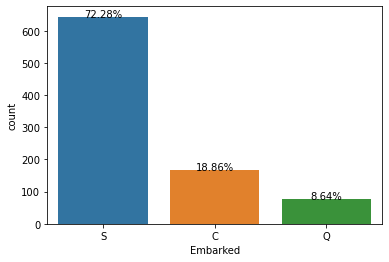

In [84]:
barplot('Embarked',train_data)

### Most of the passengers embarked from Southampton 

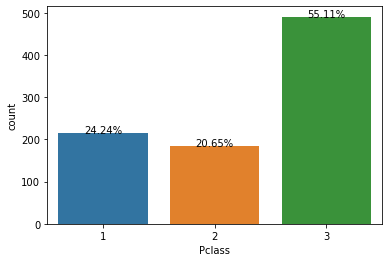

In [85]:
barplot('Pclass',train_data)

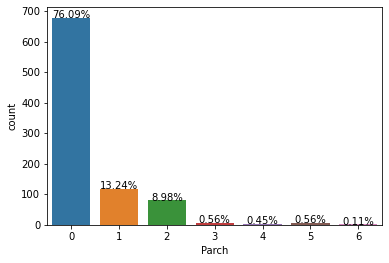

In [86]:
barplot('Parch',train_data)

(array([ 50.,  33., 164., 358., 123.,  74.,  50.,  26.,  11.,   2.]),
 array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72., 80.]),
 <a list of 10 Patch objects>)

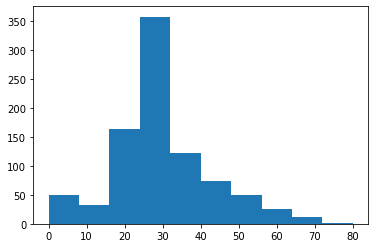

In [87]:
plt.hist(train_data['Age'])

In [80]:
def getProbOfNoShow(col, target, train_data, forGraph=True):
    crosstab = pd.crosstab(index=train_data[col], columns=train_data[target])
    crosstab.columns = pd.Index(list(crosstab.columns))
    crosstab = crosstab.reset_index()
    crosstab['total'] = crosstab['Yes'] + crosstab['No']
    crosstab['prob'] = crosstab['Yes']/crosstab['total']
    if forGraph:
        return crosstab[[col,'prob']]
    else:
        return crosstab[[col,'total','prob']]

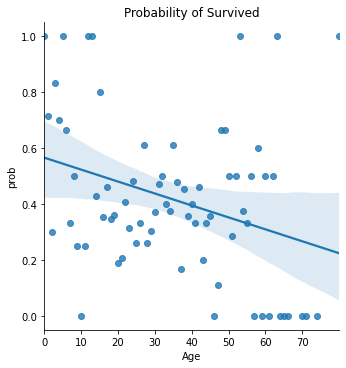

In [81]:
data = getProbOfNoShow('Age', 'Survived', train_data)
sns.lmplot(data = data, x = 'Age', y = 'prob', fit_reg = True)
plt.xticks(np.arange(np.min(train_data['Age']), np.max(train_data['Age']), 10))
plt.title('Probability of Survived')
plt.show()

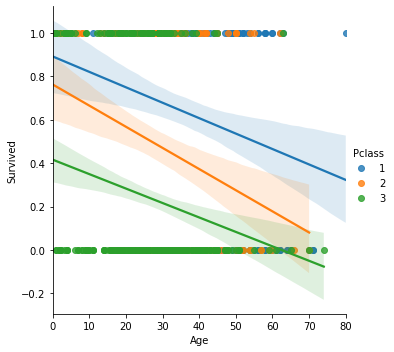

In [112]:
sns.lmplot('Age','Survived',hue='Pclass',data=train_data)

### It seems to be that older people were less likely to survive.

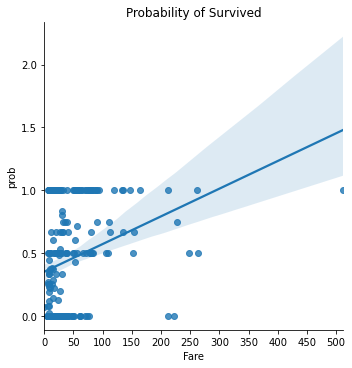

In [35]:
data = getProbOfNoShow('Fare', 'Survived', train_data)
sns.lmplot(data = data, x = 'Fare', y = 'prob', fit_reg = True)
plt.xticks(np.arange(np.min(train_data['Fare']), np.max(train_data['Fare']), 50))
plt.title('Probability of Survived')
plt.show()

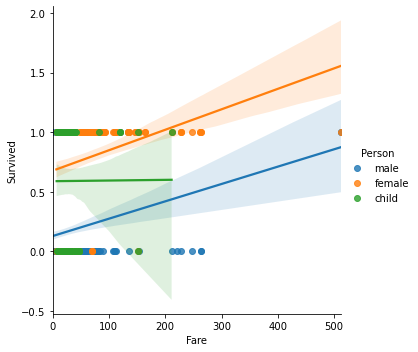

In [114]:
sns.lmplot('Fare','Survived',hue='Person',data=train_data)

### Irrespective to gender,as fare increases the survival rate also increases.

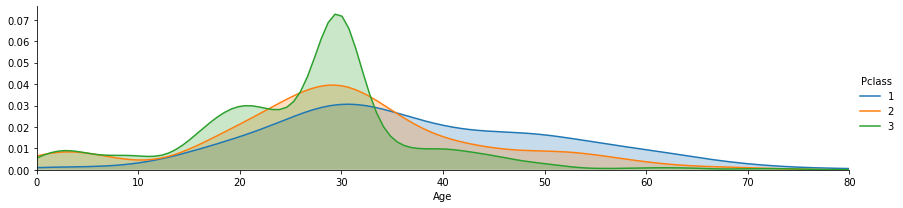

In [44]:
fig = sns.FacetGrid(train_data,hue='Pclass',aspect=4)
fig.map(sns.kdeplot,'Age',shade=True)
oldest = train_data['Age'].max()
fig.set(xlim=(0,oldest))
fig.add_legend()

### we see that the first class is normally distributed. Age 20-30 were considerably high in third class.

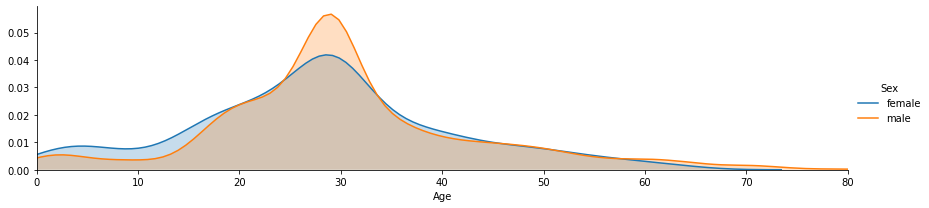

In [118]:
fig = sns.FacetGrid(train_data,hue='Sex',aspect=4)

fig.map(sns.kdeplot,'Age',shade=True)

oldest = train_data['Age'].max()

fig.set(xlim=(0,oldest))

fig.add_legend()

In [108]:
temp = train_data.groupby(['Pclass','Survived']).size().to_frame()
temp = temp.reset_index()
temp.columns = ['Pclass','Survived','Count']
trace1 = go.Bar(x=temp.Pclass[temp.Survived==1],
               y=temp.Count[temp.Survived==1]/temp.Count.sum(), name='Survived')
trace2 = go.Bar(x=temp.Pclass[temp.Survived==0],
               y=temp.Count[temp.Survived==0]/temp.Count.sum(), name='Not Survived')

data = [trace1, trace2]
layout=go.Layout(width=800, height=500, title='P Class')
fig = go.Figure(data=data, layout=layout)
fig.show()

In [111]:
temp = train_data.groupby(['Pclass','Person']).size().to_frame()
temp = temp.reset_index()
temp.columns = ['Pclass','Person','Count']
trace1 = go.Bar(x=temp.Pclass[temp.Person=='male'],
               y=temp.Count[temp.Person=='male']/temp.Count.sum(), name='Male')
trace2 = go.Bar(x=temp.Pclass[temp.Person=='female'],
               y=temp.Count[temp.Person=='female']/temp.Count.sum(), name='Female')
trace3 = go.Bar(x=temp.Pclass[temp.Person=='child'],
               y=temp.Count[temp.Person=='child']/temp.Count.sum(), name='Child')

data = [trace1, trace2, trace3]
layout=go.Layout(width=800, height=500, title='P Class')
fig = go.Figure(data=data, layout=layout)
fig.show()

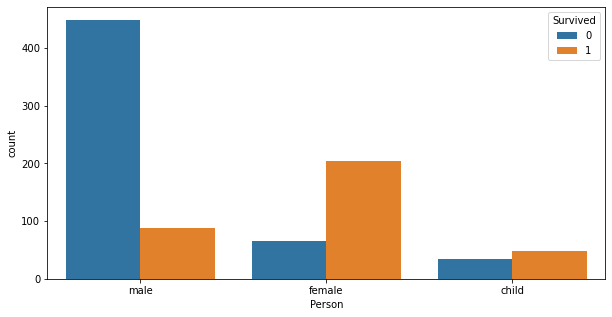

In [53]:
fig, ax =plt.subplots(figsize=(10,5))
sns.countplot(train_data['Person'], hue=train_data['Survived'], ax=ax)

In [59]:
train_data['Survived'] = train_data['Survived'].replace(to_replace=[0,1], value=['No' , 'Yes'])
train_data['Survived'].value_counts()

No     549
Yes    342
Name: Survived, dtype: int64

In [64]:
trace1 = go.Box(y=train_data.Fare[train_data.Survived=='Yes'], name='Yes')
trace2 = go.Box(y=train_data.Fare[train_data.Survived=='No'], name='No')
data = [trace1, trace2]
layout = go.Layout(width=800, height=500, title='Survived or not')
fig = go.Figure(data=data, layout=layout)
fig.show()

In [66]:
trace1 = go.Box(y=train_data.Age[train_data.Survived=='Yes'], name='Survived')
trace2 = go.Box(y=train_data.Age[train_data.Survived=='No'], name='Not Survived')
data = [trace1, trace2]
layout = go.Layout(width=800, height=500, title='Survived or not')
fig = go.Figure(data=data, layout=layout)
fig.show()

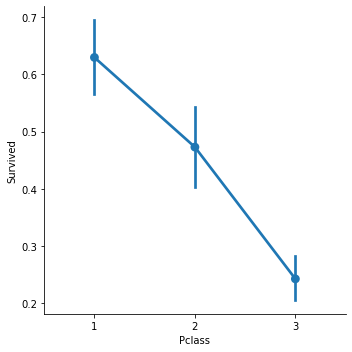

In [109]:
sns.factorplot('Pclass','Survived',data=train_data)

### It seems like lower class passengers had a lower chance of survival.

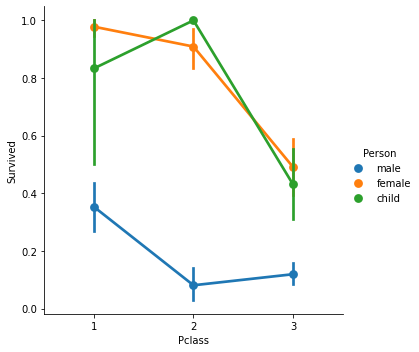

In [110]:
sns.factorplot('Pclass','Survived',hue='Person',data=train_data)

### Men had lower chances of survival than women and children.

### We can still generally say that majority of men belong to 3rd class had a lesser chance at survival than 1st class and 2nd class.

In [119]:
train_data['Survived'] = train_data['Survived'].astype('category')


In [100]:
train_data['Survived'] = train_data['Survived'].replace(to_replace=['No','Yes'], value=[0 , 1])
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [128]:
train_data['Person']=train_data['Person'].astype('category')

In [122]:
train_data.drop(['PassengerId','Name','Ticket','Cabin','Embarked','Sex'],axis=1,inplace=True)

In [ ]:
y = train_data['Survived']
X = train_data.drop('Survived',axis=1)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.30,stratify=y,random_state=107)

In [ ]:
num_attr = X_train.select_dtypes(['int64','float64']).columns
cat_attr = X_train.select_dtypes('category').columns

In [ ]:
impute = SimpleImputer(strategy='median')
impute.fit(X_train[num_attr])
X_train[num_attr] = impute.transform(X_train[num_attr])
X_val[num_attr] = impute.transform(X_val[num_attr])

In [ ]:
standard = StandardScaler()
standard.fit(X_train[num_attr])

X_train_std = standard.transform(X_train[num_attr])
X_val_std = standard.transform(X_val[num_attr])

X_train_num = pd.DataFrame(X_train_std, columns=num_attr)
X_val_num = pd.DataFrame(X_val_std, columns=num_attr)

In [ ]:
ohe = OneHotEncoder()
ohe.fit(X_train[cat_attr])
ohe_cols = list(ohe.get_feature_names(cat_attr))
X_train_ohe = ohe.transform(X_train[cat_attr])
X_val_ohe = ohe.transform(X_val[cat_attr])

X_train_cat = pd.DataFrame(X_train_ohe.todense(), columns=ohe_cols)
X_val_cat = pd.DataFrame(X_val_ohe.todense(), columns=ohe_cols)

X_train = pd.concat([X_train_num,X_train_cat],axis=1)
X_val = pd.concat([X_val_num,X_val_cat],axis=1)

In [ ]:
X_train.shape

## Decision Tree

In [ ]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train,y_train)

tree_pred_train = clf.predict(X_train)
tree_pred_test = clf.predict(X_val)

accuracy_train = accuracy_score(tree_pred_train,y_train)
accuracy_test = accuracy_score(tree_pred_test,y_val)
print(accuracy_train)
print(accuracy_test)

In [ ]:
import numpy as np
importances = clf.feature_importances_
indices = np.argsort(importances)

import matplotlib.pyplot as plt
%matplotlib inline

features = X_train.columns
plt.figure(figsize=(10,10))
plt.title('Feature_Importances')
plt.barh(range(len(features)) ,importances[indices])
plt.yticks(range(len(features)), [features[i] for i in indices], fontsize=10)
plt.xlabel('Importances')

plt.show()

In [ ]:
scores = pd.DataFrame(columns=['Model','Train_Accuracy','Train_Recall','Train_Precision','Train_F1_Score','Test_Accuracy',
                               'Test_Recall','Test_Precision','Test_F1_Score'])

def get_metrics(train_actual,train_predicted,test_actual,test_predicted,model_description,dataframe):
    train_accuracy = accuracy_score(train_actual,train_predicted)
    train_recall   = recall_score(train_actual,train_predicted,average="weighted")
    train_precision= precision_score(train_actual,train_predicted,average="weighted")
    train_f1score  = f1_score(train_actual,train_predicted,average="weighted")
    test_accuracy = accuracy_score(test_actual,test_predicted)
    test_recall   = recall_score(test_actual,test_predicted,average="weighted")
    test_precision= precision_score(test_actual,test_predicted,average="weighted")
    test_f1score  = f1_score(test_actual,test_predicted,average="weighted")
    dataframe = dataframe.append(pd.Series([model_description, train_accuracy,train_recall,train_precision,train_f1score,
                                            test_accuracy,test_recall,test_precision,test_f1score],
                                           index=scores.columns ), ignore_index=True)
    return(dataframe)

scores = get_metrics(tree_pred_train,y_train,tree_pred_test,y_val,"Decision Tree",scores)
scores

In [ ]:
param_grid = {
    'criterion': ['entropy','gini'],
    'max_depth': [None,5,6,7],
    'min_samples_split': [4,6,8],
    'min_samples_leaf' : [2,3,4],
    "max_leaf_nodes": [None,15,20,25,30],
}

dt = DecisionTreeClassifier()
grid = GridSearchCV(dt, param_grid,cv=10)
grid.fit(X_train,y_train)

grid_train =grid.predict(X_train)
grid_val = grid.predict(X_val)

grid_train_acc = accuracy_score(grid_train,y_train)
grid_val_acc = accuracy_score(grid_val,y_val)
print(grid_train_acc)
print(grid_val_acc)

In [ ]:
grid.best_params_

In [ ]:
scores = get_metrics(grid_train,y_train,grid_val,y_val,"Grid_Decision_Trees",scores)
scores

## Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=250,max_depth=5,n_jobs=-1)
rf.fit(X_train,y_train)

rf_pred_train = rf.predict(X_train)
rf_pred_test = rf.predict(X_val)

rf_train_acc = accuracy_score(rf_pred_train,y_train)
rf_val_acc = accuracy_score(rf_pred_test,y_val)
print(rf_train_acc)
print(rf_val_acc)

In [ ]:
scores = get_metrics(y_train,rf_pred_train,y_val,rf_pred_test,"Random_foresr",scores)
scores

In [ ]:
## Randamized search
## Set Up Hyperparameter Distributions

# Check max_features>0% & max_features<=100%
max_features = np.round(np.random.normal(loc=0.25, scale=0.1, size=15),2)
max_features[max_features <= 0.01] = 0.01
max_features[max_features > 1.0] = 1.0

model_params = {
    # randomly sample numbers from 4 to 100 estimators
    'n_estimators': np.random.uniform(10,100, 10).astype(int),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': list(max_features),
    # uniform distribution from 0.01 to 0.2
    'min_samples_split': np.round(np.random.uniform(0.01, 0.2, 10),2),
    # randomly sample numbers from 4 to 15
    'max_depth': np.random.uniform(2,20, 10).astype(int)
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf1 = RandomizedSearchCV(estimator=rf, param_distributions=model_params, n_iter=300, cv=5, n_jobs=-1)
rf1.fit(X_train, y_train)

In [ ]:
rf1.best_params_

In [ ]:
rf2 = RandomForestClassifier()

param = {
    'n_estimators': [91,93,95,97,99],
    'min_samples_split': [0.05,0.07,0.09,0.11,0.13],
    'max_features': [0.19,0.21,0.23,0.25,0.27],
    'max_depth': [15,17,19,21,23],
}

grid1 = GridSearchCV(rf2, param,cv=10)
grid1.fit(X_train,y_train)

grid1_rf_train =grid1.predict(X_train)
grid1_rf_val = grid1.predict(X_val)

grid1_rf_train_acc = accuracy_score(grid1_rf_train,y_train)
grid1_rf_val_acc = accuracy_score(grid1_rf_val,y_val)
print(grid1_rf_train_acc)
print(grid1_rf_val_acc)

In [ ]:
scores = get_metrics(y_train,grid1_rf_train,y_val,grid1_rf_val,"Random_forest_RandomizedSearch",scores)
scores

In [ ]:
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)

ada_pred_train = ada.predict(X_train)
ada_pred_test = ada.predict(X_val)

ada_train_acc = accuracy_score(ada_pred_train,y_train)
ada_val_acc = accuracy_score(ada_pred_test,y_val)
print(ada_train_acc)
print(ada_val_acc)

In [ ]:
scores = get_metrics(y_train,ada_pred_train,y_val,ada_pred_test,"Ada_boost",scores)
scores

In [ ]:
XGB_model = XGBClassifier()
%time XGB_model.fit(X_train, y_train)

xgboost_pred_train = XGB_model.predict(X_train)
xgboost_pred_test = XGB_model.predict(X_val)

xg_train_acc = accuracy_score(xgboost_pred_train,y_train)
xg_val_acc = accuracy_score(xgboost_pred_test,y_val)
print(xg_train_acc)
print(xg_val_acc)

In [ ]:
scores = get_metrics(y_train,xgboost_pred_train,y_val,xgboost_pred_test,"XG_boost",scores)
scores

In [ ]:
xg=XGBClassifier()

parameters = {
    'n_estimators': [30,35],
    'gamma' : [0.90,0.95,0.98],
    'learning_rate' : [0.1,0.15,0.20],
}

grid_search = GridSearchCV(xg, parameters,cv=10)
grid_search.fit(X_train,y_train)

xg_grid_train = grid_search.predict(X_train)
xg_grid_test = grid_search.predict(X_val)

grid_train_acc = accuracy_score(xg_grid_train,y_train)
grid_test_acc = accuracy_score(xg_grid_test,y_val)
print(grid_train_acc)
print(grid_test_acc)

In [ ]:
scores = get_metrics(y_train,xg_grid_train,y_val,xg_grid_test,"XG_boost_Gridcv",scores)
scores

## Test Data

In [ ]:
test_data.dtypes

In [ ]:
test_data.drop(['Embarked','Cabin','Ticket','Name'],axis=1,inplace=True)

In [ ]:
cat_c = ['Pclass','Sex','SibSp','Parch']
for cat in cat_c:
    test_data[cat] = test_data[cat].astype('category')

In [ ]:
one_hot = OneHotEncoder()
one_hot.fit(test_data[cat_c])
one_hot_col = list(one_hot.get_feature_names(cat_c))

test_ohe = one_hot.transform(test_data[cat_c])
test_dummy = pd.DataFrame(test_ohe.todense(), columns=one_hot_col)

In [ ]:
num_col = test_data.select_dtypes(['int64','float64']).columns


imp=SimpleImputer(strategy='median')
imp.fit(test_data[num_col])

test_imp = pd.DataFrame(imp.transform(test_data[num_col]), columns=num_col)
test_imp.head(2)

In [ ]:
test_imp.drop('PassengerId',axis=1,inplace=True)

In [ ]:
test_final = pd.concat([test_imp,test_dummy],axis=1)
test_final.drop('Parch_9',axis=1,inplace=True)

In [ ]:
prediction = grid.predict(test_final)
prediction = pd.DataFrame(prediction)

In [ ]:
prediction[0]

In [ ]:
final_submission = pd.read_csv("/kaggle/input/titanic/test.csv")
final_submission['Report'] = prediction[0]

In [ ]:
output = pd.DataFrame({'PassengerId': final_submission.PassengerId, 'Survived': final_submission.Report})

In [ ]:
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
output.loc[(output.Survived==1),].sum()

In [ ]:
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")